Class distribution in full dataset: [24950    50]
Model Metrics:
Accuracy: 0.9991
Precision: 0.9000
Recall: 0.6000
F1 Score: 0.7200
AUC: 0.9996

Top 10 Hackers Detected Using Logistic Regression:
--------------------------------------------------
#1: Player P21810 - Probability: 0.998
   Factors: Unusual quest patterns, Dark market activity, Excessive spending
   -----------------------------
#2: Player P1030 - Probability: 0.997
   Factors: Unusual quest patterns, Dark market activity, Excessive spending
   -----------------------------
#3: Player P9060 - Probability: 0.997
   Factors: Unusual quest patterns, Dark market activity, Excessive spending, Excessive playtime
   -----------------------------
#4: Player P4440 - Probability: 0.996
   Factors: Unusual quest patterns, Dark market activity, Excessive spending, Excessive playtime
   -----------------------------
#5: Player P9149 - Probability: 0.995
   Factors: Unusual quest patterns, Dark market activity, Excessive spending, Exce

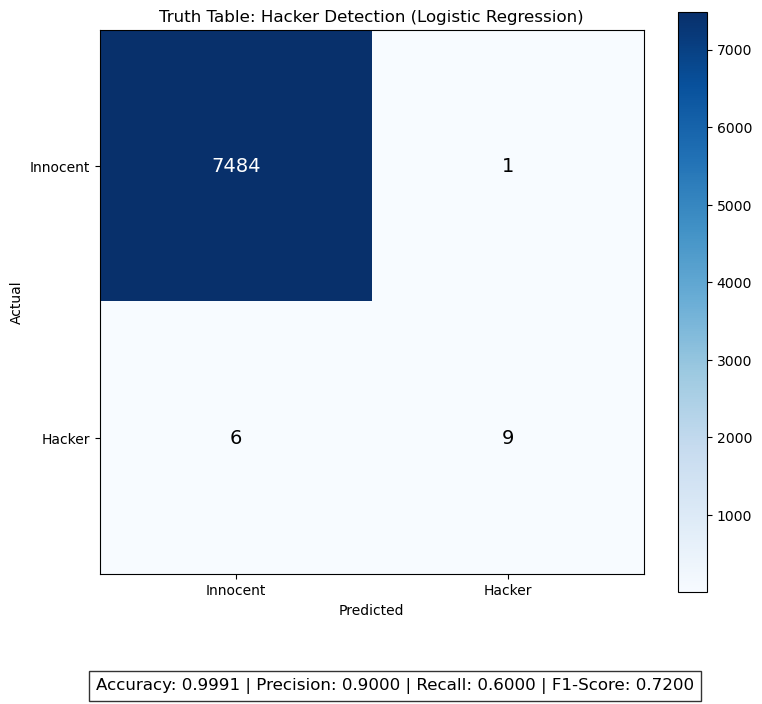

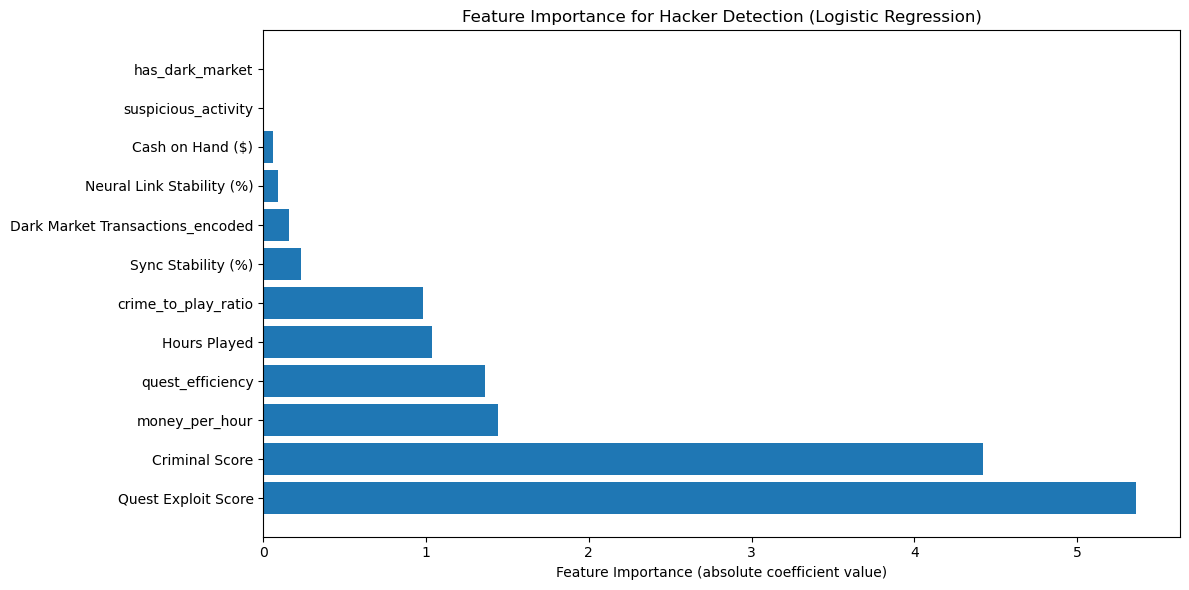

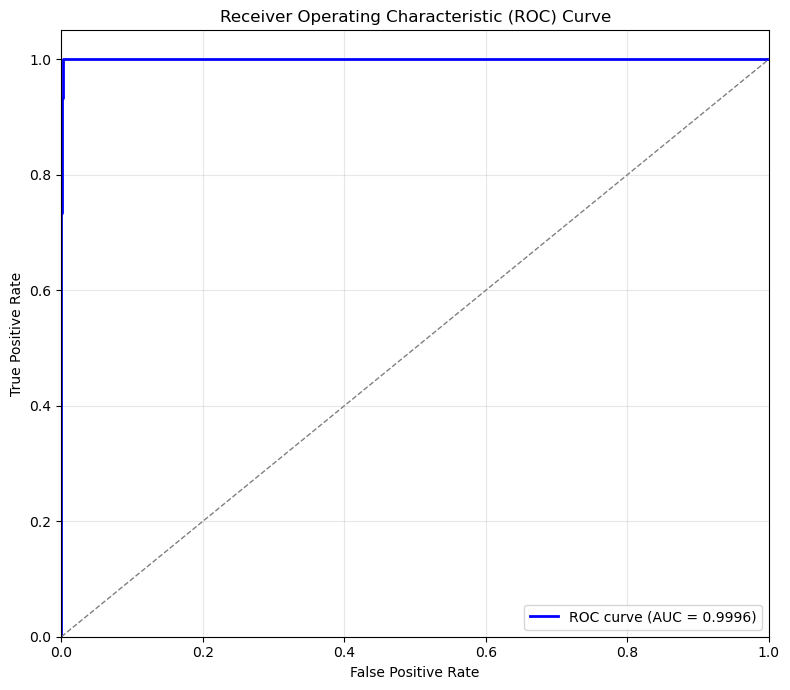

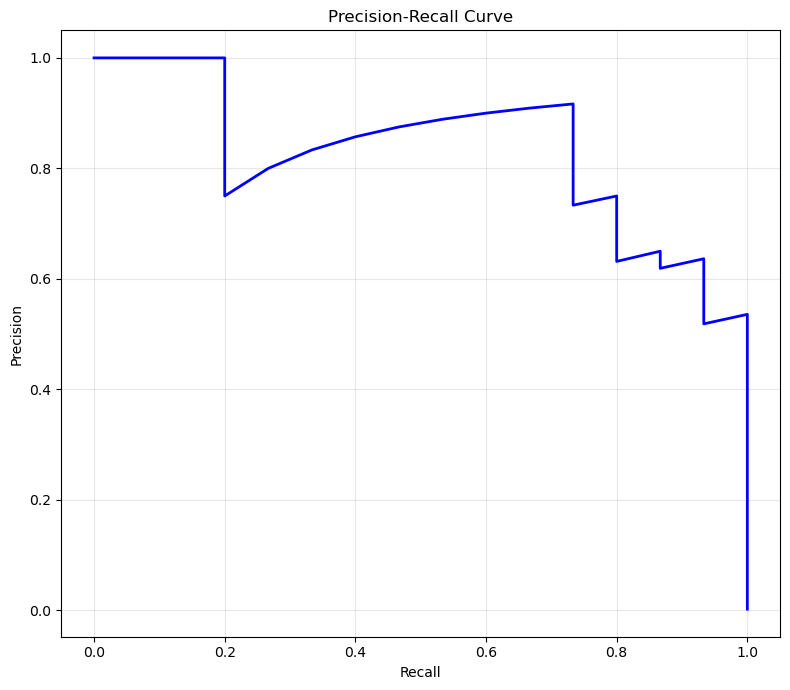

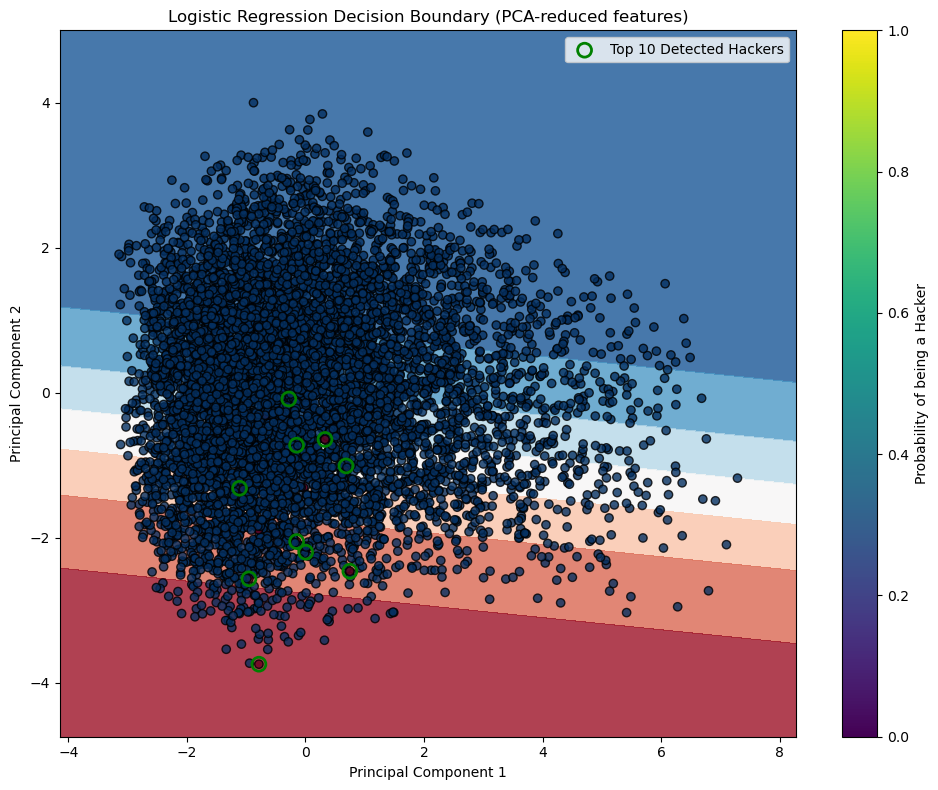

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.decomposition import PCA

# Load data
data = pd.read_csv("perfect_prediction_neoverse_logs.csv")

# Preprocessing
warnings.filterwarnings("ignore")
np.random.seed(42)

# Save original data for CSV output later
original_data = data.copy()

# Handle timestamp column
timestamp_col = "Timestamps" if "Timestamps" in data.columns else "Timestamp"
data[timestamp_col] = pd.to_datetime(data[timestamp_col])
data.drop(columns=[timestamp_col], inplace=True)

categorical_columns = ['Player ID', 'Player Rank', 'Team Affiliation', 'VIP Status',
                       'Player Level', 'Dark Market Transactions']
numerical_columns = ['Hours Played', 'Money Spent ($)', 'Criminal Score', 'Missions Completed',
                     'Cash on Hand ($)', 'Sync Stability (%)', 'Quest Exploit Score',
                     'Transaction Amount ($)', 'Neural Link Stability (%)']

# Feature engineering
for col in numerical_columns:
    if col in data.columns:
        # Add ratio features
        if 'Criminal Score' in data.columns and col != 'Criminal Score':
            data[f'{col}_to_criminal_ratio'] = data[col] / \
                (data['Criminal Score'] + 1)

# Add interaction features
data['crime_to_play_ratio'] = data['Criminal Score'] / \
    (data['Hours Played'] + 1)
data['money_per_hour'] = data['Money Spent ($)'] / (data['Hours Played'] + 1)
data['quest_efficiency'] = data['Quest Exploit Score'] / \
    (data['Hours Played'] + 1)
data['suspicious_activity'] = ((data['crime_to_play_ratio'] > data['crime_to_play_ratio'].quantile(0.95)) &
                               (data['Quest Exploit Score'] > data['Quest Exploit Score'].quantile(0.95))).astype(int)

# Categorical encoding
for col in categorical_columns:
    le = LabelEncoder()
    data[f"{col}_encoded"] = le.fit_transform(data[col])

# Dark market flag
data['has_dark_market'] = (
    data['Dark Market Transactions'] != 'None').astype(int)

# Compute suspicion score based on domain knowledge
data['suspicion_score'] = (
    0.3 * (data['Criminal Score'] / data['Criminal Score'].max()) +
    0.2 * (data['Quest Exploit Score'] / data['Quest Exploit Score'].max()) +
    0.2 * (data['money_per_hour'] / data['money_per_hour'].max()) +
    0.3 * data['has_dark_market']
)

# Select top 20% most suspicious players for training (to avoid class imbalance issues)
threshold = data['suspicion_score'].quantile(0.998)
data['potential_hacker'] = (data['suspicion_score'] > threshold).astype(int)

# Feature selection for logistic regression
features = [
    "Hours Played", "Criminal Score", "Quest Exploit Score",
    "Cash on Hand ($)", "Sync Stability (%)", "Neural Link Stability (%)",
    "money_per_hour", "crime_to_play_ratio", "quest_efficiency",
    "Dark Market Transactions_encoded", "has_dark_market",
    "suspicious_activity"
]

X = data[features]
y = data['potential_hacker']

# Check class distribution
print(f"Class distribution in full dataset: {np.bincount(y)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression(
    C=1.0,                    # Regularization strength
    class_weight='balanced',  # Handle class imbalance
    max_iter=1000,            # Increase iterations to ensure convergence
    random_state=42,
    solver='liblinear'        # Works well with small datasets
)
model.fit(X_train_scaled, y_train)

# Predict probabilities
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Get exactly 10 hackers - the ones with highest probability
# Instead of using a fixed threshold, pick the top 10
top_10_indices = np.argsort(y_prob)[-10:]
y_pred = np.zeros_like(y_test)
y_pred[top_10_indices] = 1

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)

print(f"Model Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Create confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 7))

# Use a custom colormap for better visualization
cmap = plt.cm.Blues
plt.imshow(cm, interpolation='nearest', cmap=cmap)
plt.title('Truth Table: Hacker Detection (Logistic Regression)')
plt.colorbar()

# Set tick marks and labels
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Innocent', 'Hacker'])
plt.yticks(tick_marks, ['Innocent', 'Hacker'])

# Add text annotations in each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()

# Add metrics to the plot
plt.figtext(0.5, 0.01, f'Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}',
            ha='center', fontsize=12, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5, 'edgecolor': 'black'})

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.savefig("hacker_truth_table.png")
# Show feature importances (coefficients for logistic regression)
feature_importances = np.abs(model.coef_[0])
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [features[i] for i in sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_features)
plt.xlabel('Feature Importance (absolute coefficient value)')
plt.title('Feature Importance for Hacker Detection (Logistic Regression)')
plt.tight_layout()
plt.savefig("feature_importance.png")

# Visualize ROC curve
plt.figure(figsize=(8, 7))
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curve.png")

# Visualize Precision-Recall curve
plt.figure(figsize=(8, 7))
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall_curve, precision_curve, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("precision_recall_curve.png")

# PCA for visualization of the data and decision boundary
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

# Visualize the logistic regression decision boundary
plt.figure(figsize=(10, 8))

# Create a mesh grid
h = 0.02  # step size in the mesh
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Train a logistic regression model on the PCA data for visualization
pca_model = LogisticRegression(class_weight='balanced', random_state=42)
pca_model.fit(X_test_pca, y_test)

# Predict probabilities on the mesh grid
Z = pca_model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu_r)

# Plot the data points
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test,
            cmap=plt.cm.RdBu_r, alpha=0.8, edgecolors='black')

# Highlight the top 10 predicted hackers
plt.scatter(X_test_pca[top_10_indices, 0], X_test_pca[top_10_indices, 1],
            s=100, facecolors='none', edgecolors='green', linewidth=2,
            label='Top 10 Detected Hackers')

plt.title('Logistic Regression Decision Boundary (PCA-reduced features)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Probability of being a Hacker')
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("logistic_regression_boundary.png")

# Get the original data for the top 10 suspicious players
test_indices = X_test.index
top_10_original_indices = test_indices[top_10_indices]
top_10_hackers_data = original_data.iloc[top_10_original_indices].copy()

# Add prediction information
top_10_hackers_data['Hacker_Probability'] = y_prob[top_10_indices]
top_10_hackers_data['Actual_Label'] = y_test.iloc[top_10_indices].values
top_10_hackers_data['Suspicion_Score'] = data.iloc[top_10_original_indices]['suspicion_score'].values

# Sort by probability
top_10_hackers_data = top_10_hackers_data.sort_values(
    'Hacker_Probability', ascending=False)
top_10_hackers_data['Hacker_Rank'] = range(1, len(top_10_hackers_data) + 1)

# Add suspicion factors
top_10_hackers_data['Suspicion_Factors'] = ''
for idx, row in top_10_hackers_data.iterrows():
    factors = []

    if row['Criminal Score'] > data['Criminal Score'].quantile(0.9):
        factors.append("High criminal score")
    if row['Quest Exploit Score'] > data['Quest Exploit Score'].quantile(0.9):
        factors.append("Unusual quest patterns")
    if row['Dark Market Transactions'] != 'None':
        factors.append("Dark market activity")
    if row['Money Spent ($)'] > data['Money Spent ($)'].quantile(0.95):
        factors.append("Excessive spending")
    if row['Hours Played'] > data['Hours Played'].quantile(0.95):
        factors.append("Excessive playtime")

    top_10_hackers_data.at[idx, 'Suspicion_Factors'] = ", ".join(factors)

# Save to CSV
top_10_hackers_data.to_csv(
    "top_10_hackers_logistic_regression.csv", index=False)

# Print a summary of the detected hackers
print("\nTop 10 Hackers Detected Using Logistic Regression:")
print("--------------------------------------------------")
for i, (idx, row) in enumerate(top_10_hackers_data.iterrows()):
    print(
        f"#{i+1}: Player {row['Player ID']} - Probability: {row['Hacker_Probability']:.3f}")
    print(f"   Factors: {row['Suspicion_Factors']}")
    print("   -----------------------------")

# Print full classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=[
      "Innocent", "Hacker"], zero_division=0))

In [ ]:
data = pd.read_csv("true_positive_hackers_logistic_regression.csv")

In [33]:
data

,Player ID,Timestamps,Hours Played,Money Spent ($),Criminal Score,Missions Completed,Player Rank,Team Affiliation,VIP Status,Cash on Hand ($),...,Quest Exploit Score,Player Level,Dark Market Transactions,Transaction Amount ($),Neural Link Stability (%),Hacker_Probability,Actual_Label,Suspicion_Score,Hacker_Rank,Suspicion_Factors
0,P21810,2025-02-17 22:17:06,259,24355.84,9,376,Solar Admiral,Cyber Sentinels,Yes,2348,...,701.6,Cosmic Initiate,RealityBender,10484,80.566514,0.998219,1,0.948448,1,"Unusual quest patterns, Dark market activity, ..."
1,P1030,2025-02-16 12:45:07,274,25432.16,9,362,Stellar Scout,Shadow Collective,Yes,745,...,708.4,Cosmic Initiate,RealityBender,3298,79.769782,0.996979,1,0.947935,2,"Unusual quest patterns, Dark market activity, ..."
2,P9060,2025-02-16 18:27:37,298,27642.40,9,323,Cosmic Ensign,Cyber Sentinels,Yes,4643,...,706.0,Cosmic Initiate,RealityBender,5046,84.724271,0.996522,1,0.947278,3,"Unusual quest patterns, Dark market activity, ..."
3,P9149,2025-02-17 22:53:24,292,22598.40,9,436,Nebula Novice,Lone Wolf,No,14156,...,789.2,Quantum Sovereign,Error404,9023,92.240134,0.995019,1,0.939725,4,"Unusual quest patterns, Dark market activity, ..."
4,P8240,2025-02-16 02:53:37,294,26812.16,9,332,Stellar Scout,Lone Wolf,Yes,8625,...,708.4,Cosmic Initiate,RealityBender,3038,72.960541,0.994962,1,0.944991,5,"Unusual quest patterns, Dark market activity, ..."
5,P14810,2025-02-15 15:24:57,283,25848.80,9,328,Solar Admiral,Lone Wolf,Yes,8916,...,692.0,Cosmic Initiate,RealityBender,13417,88.637581,0.992878,1,0.941132,6,"Unusual quest patterns, Dark market activity, ..."
6,P0068,2025-02-15 23:40:26,297,22766.80,9,440,Solar Admiral,Lone Wolf,No,1972,...,798.4,Celestial Vanguard,ByteBandit,11940,80.699077,0.992312,1,0.940674,7,"Unusual quest patterns, Dark market activity, ..."
7,P19059,2025-02-15 12:22:26,285,22546.80,9,408,Solar Admiral,Cyber Sentinels,No,5451,...,758.4,Quantum Sovereign,Error404,2894,109.636736,0.987154,1,0.935189,8,"Unusual quest patterns, Dark market activity, ..."
8,P11750,2025-02-15 16:58:43,244,22483.52,9,340,Galactic Commander,Lone Wolf,Yes,9508,...,654.8,Cosmic Initiate,RealityBender,3575,99.244636,0.984933,1,0.933233,9,"Unusual quest patterns, Dark market activity, ..."
